In [67]:
# Imports
%matplotlib notebook
import cvxpy as cp
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver
from local_solver import projection_error, StereoLocalizationProblem
from sdp_relaxation import (
    build_general_SDP_problem,
    block_diagonal,
    build_cost_matrix_v2,
    build_rotation_constraint_matrices,
    build_measurement_constraint_matrices_v2,
    build_measurement_constraint_matrices,
    build_parallel_constraint_matrices,
    extract_solution_from_X,
    build_homo_constraint,
)
import mosek
import iterative_sdp
import scipy as sp

In [177]:
# make camera
cam = sim.Camera(
    f_u = 484.5,
    f_v = 484.5, 
    c_u = 322,
    c_v = 247,
    b = 0.24,
    R = 1 * np.eye(4),
    fov_phi_range = (-np.pi/12, np.pi/12),
    fov_depth_range = (0.2, 3),
)
world = sim.World(
    cam = cam,
    p_wc_extent = np.array([[3], [3], [0]]),
    num_landmarks = 10,
)
use_redundant=False

<IPython.core.display.Javascript object>


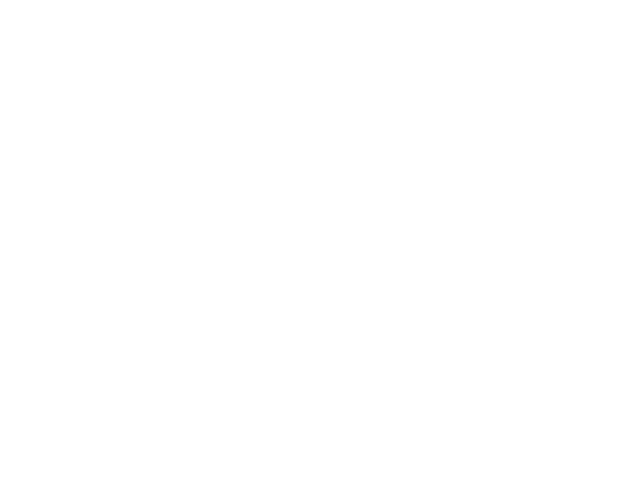

<IPython.core.display.Javascript object>


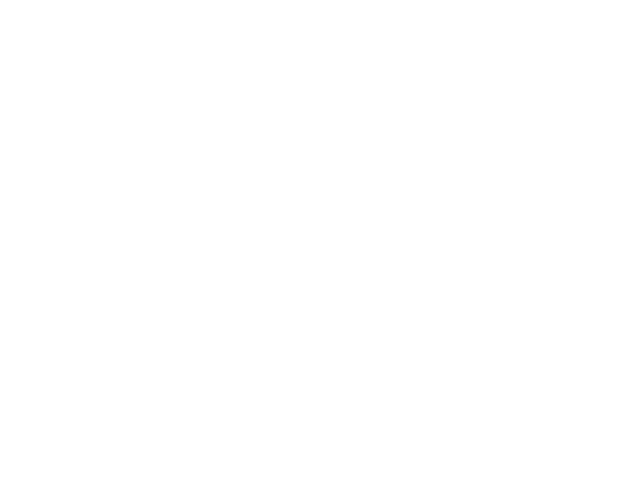

In [198]:
# make random camera pose
"""a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 5
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, cam.fov)"""

world.clear_sim_instance()
world.make_random_sim_instance()
fig, ax, colors = world.render()

# Generative camera model 
y = cam.take_picture(world.T_wc, world.p_w)
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

In [199]:
if False: # tims problem
        # groundtruth pose
        T_cw = np.array([[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 1.2], [0, 0, 0, 1]])  

        # groundtruth landmarks
        J = 5;
        p_w = np.zeros((J,4,1))
        p_w[0,:,:] = np.matrix('1; 1; 2; 1')
        p_w[1,:,:] = np.matrix('1; -1; 2; 1')
        p_w[2,:,:] = np.matrix('-1; 1; 2; 1')
        p_w[3,:,:] = np.matrix('-1; -1; 2; 1')
        p_w[4,:,:] = np.matrix('0; 0; 3; 1')
        
        world.p_w = p_w
        world.T_wc = np.linalg.inv(T_cw)

        a = np.array([[0], [0], [1], [0]])

        # constant camera matrix
        b = 0.2
        f_u = 100
        f_v = 100
        c_u = 50
        c_v = 50
        
        cam = sim.Camera(
            f_u = f_u, # focal length in horizonal pixels
            f_v = f_v, # focal length in vertical pixels
            c_u = c_u, # pinhole projection in horizonal pixels
            c_v = c_v, # pinhold projection in vertical pixels
            b = b, # baseline (meters)
            R = 0 * np.eye(4), # covarience matrix for image-space noise
            fov = np.array([[-1,1], [-1, 1], [2, 5]])
        )

        
        # generate measurements with small amount of noise
        world.cam = cam
        y = cam.take_picture(world.T_wc, world.p_w)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [200]:
W =  np.eye(4)
r0 = np.zeros((3, 1))
gamma_r = 0
T_op = np.eye(4)

problem = StereoLocalizationProblem(world.T_wc, world.p_w, cam.M(), W, y, r_0 = r0, gamma_r = gamma_r)
problem.T_init = T_op
solution = local_solver.stereo_localization_gauss_newton(problem, log = True)
T_op = solution.T_cw
local_minima = solution.cost
print("Estimate:\n", T_op)
print("Ground Truth:\n", np.linalg.inv(world.T_wc))

Loss: [[4.82814758e+08]]
Loss: [[4.34496423e+09]]
Loss: [[1.22151551e+09]]
Loss: [[3.17401768e+08]]
Loss: [[1.62676143e+08]]
Loss: [[1.16258101e+08]]
Loss: [[1.3066703e+08]]
Loss: [[1.15940781e+08]]
Loss: [[2.74727333e+08]]
Loss: [[1.32824801e+08]]
Loss: [[1.12017681e+08]]
Loss: [[1.14006878e+08]]
Loss: [[1.05859796e+08]]
Loss: [[1.33951897e+08]]
Loss: [[1.34362751e+08]]
Loss: [[95579982.28258304]]
Loss: [[1.02045838e+08]]
Loss: [[1.79470309e+08]]
Loss: [[1.03876305e+08]]
Loss: [[1.23380823e+08]]
Loss: [[1.03283105e+08]]
Loss: [[1.27036943e+08]]
Loss: [[1.45483969e+08]]
Loss: [[96616295.506803]]
Loss: [[1.15979392e+08]]
Loss: [[96498342.8394935]]
Loss: [[1.19461894e+08]]
Loss: [[98141926.26942545]]
Loss: [[1.06664413e+08]]
Loss: [[1.33037691e+08]]
Loss: [[1.45204744e+08]]
Loss: [[96239559.44341132]]
Loss: [[1.07013204e+08]]
Loss: [[1.22700584e+08]]
Loss: [[1.01842746e+08]]
Loss: [[1.04123592e+08]]
Loss: [[1.26230398e+08]]
Loss: [[1.01163474e+08]]
Loss: [[1.05478385e+08]]
Loss: [[1.3832

Loss: [[1441852.07540518]]
Loss: [[1363872.90144451]]
Loss: [[1985139.55674225]]
Loss: [[1313533.34297986]]
Loss: [[1306548.38080865]]
Loss: [[1324504.42467969]]
Loss: [[1345636.37636319]]
Loss: [[1775126.72774214]]
Loss: [[1313877.21649805]]
Loss: [[1320023.41348139]]
Loss: [[1342162.19157061]]
Loss: [[1703203.15040191]]
Loss: [[1319278.57937895]]
Loss: [[1357201.76328358]]
Loss: [[1369580.00999864]]
Loss: [[2129460.35101024]]
Loss: [[1322414.01561256]]
Loss: [[1322132.75660737]]
Loss: [[1462715.91700232]]
Loss: [[1359669.00461089]]
Loss: [[1900291.42816165]]
Loss: [[1311440.27007932]]
Loss: [[1302411.70512622]]
Loss: [[1301513.65471785]]
Loss: [[1301417.84584472]]
Loss: [[1301601.77763837]]
Loss: [[1302616.14599661]]
Loss: [[1306013.53907082]]
Loss: [[1328498.79727632]]
Loss: [[1351095.57175667]]
Loss: [[1850846.24294333]]
Loss: [[1311428.64646607]]
Loss: [[1304571.02538987]]
Loss: [[1309862.76910798]]
Loss: [[1353545.82457982]]
Loss: [[1366921.76396801]]
Loss: [[2101863.39901766]]
L

In [201]:
eps = 1e-10 # try 1e-10
mosek_params = {
    "MSK_DPAR_INTPNT_CO_TOL_DFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_PFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": eps,
}
X = iterative_sdp.iterative_sdp_solution(
    problem,
    np.eye(4),
    max_iters = 100,
    min_update_norm = 1e-6,
    mosek_params = mosek_params,
)

T_sdp = extract_solution_from_X(X)
print("SDP Solution:\n", T_sdp)
cost = projection_error(y, T_sdp, cam.M(), world.p_w, W)
print("SDP Solution Cost:", cost)
print("Local Solution Cost:", local_minima[0][0])

Failed to solve in 1 tries
SDP Solution:
 [[ 0.28126632  0.05215413  0.95821146 -0.40127984]
 [ 0.20942818  0.97111707 -0.11433057 -2.67926784]
 [-0.93649832  0.23283382  0.26221998  0.29720278]
 [ 0.          0.          0.          1.        ]]
SDP Solution Cost: 28.406597182531666
Local Solution Cost: 1433632.2667188612


/var/folders/_y/_blng15n30s1q2gzf3p3sw2w0000gn/T/ipykernel_61840/1392389762.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))


<IPython.core.display.Javascript object>


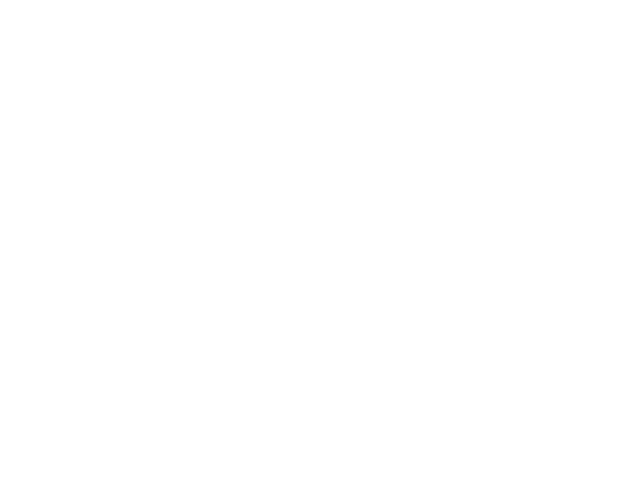

In [202]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))
plt.ylabel("$\log_{10}(\lambda)$")
plt.savefig("eigs.png")

In [203]:
e_3 = np.zeros((4, 1))
e_3[2] = 1
v = (T_op @ world.p_w) / (e_3.T @ (T_op @ world.p_w))
assert np.isclose((np.eye(4,4) - v @ e_3.T) @ (T_op @ world.p_w), 0).all()

<IPython.core.display.Javascript object>


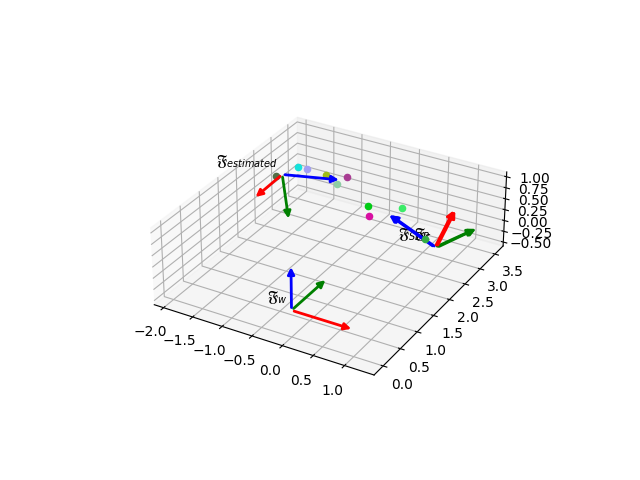

In [204]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation Math

See `math.tex`


## From Stereo Localization to QCQP, and QCQP to SDP

We will define:
$$\mathbf{x} = \begin{bmatrix} \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3 \\ \mathbf{r} \\ \mathbf{u}_1 \\ \dots \\ \mathbf{u}_n \\ \omega\end{bmatrix} \in \mathbb{R}^{13 + 3n}$$

In [205]:
# build x_local from local solution to test matricies
T_op = np.eye(4)
Ws = np.zeros((world.num_landmarks, 4, 4))
for i in range(world.num_landmarks):
    Ws[i] = W
x_1 = T_op[:3, :].T.reshape((12, 1))
x_2 = (T_op @ world.p_w / np.expand_dims((np.array([0, 0, 1, 0]) @ T_op @ world.p_w), -1))[:, [0, 1, 3], :].reshape(-1, 1)
#x_local = np.concatenate((x_1, x_2, np.array([[1]])), axis = 0)

### Cost Matrix

In [206]:
num_landmarks = world.num_landmarks
# build cost matrix and compare to local solution
Q = build_cost_matrix_v2(num_landmarks, problem.y, Ws, problem.M, problem.r_0, problem.gamma_r)
Q = Q / np.mean(np.abs(Q)) # improve numerics 
As = []
bs = []

# rotation matrix
As_rot, bs = build_rotation_constraint_matrices()
for A_rot in As_rot:
    A = np.zeros((13 + 3*num_landmarks, 13 + 3 *num_landmarks))
    A[:9, :9] = A_rot
    As.append(A)

# homogenization variable
A, b = build_homo_constraint(num_landmarks)
As.append(A)
bs.append(b)

# measurements
A_measure, b_measure = build_measurement_constraint_matrices_v2(problem.p_w)
As += A_measure
bs += b_measure

In [207]:
"""
eps = 1e-10 # try 1e-10
mosek_params = {
    "MSK_DPAR_INTPNT_CO_TOL_DFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_PFEAS": eps,
    "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": eps,
}
"""
prob, X = build_general_SDP_problem(Q, As, bs)
prob.solve(solver=cp.MOSEK, verbose = True)# , mosek_params = mosek_params)

# Print result.
print("The optimal value from the SDP is", prob.value)
print("The optimal value from the local solver is", local_minima)
#print("A solution X is")
X = X.value
print("SDP Solution rank:", np.linalg.matrix_rank(X))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jan 15 09:21:14 PM: Your problem has 1849 variables, 38 constraints, and 0 parameters.
(CVXPY) Jan 15 09:21:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 15 09:21:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 15 09:21:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 15 09:21:14 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jan 15 09:21:14 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Jan 15 09:21:15 PM:   Solution status : OPTIMAL
(CVXPY) Jan 15 09:21:15 PM:   Primal.  obj: 1.8540867778e-03    nrm: 8e+01    Viol.  con: 5e-07    var: 0e+00    barvar: 0e+00  
(CVXPY) Jan 15 09:21:15 PM:   Dual.    obj: 1.8540795971e-03    nrm: 4e+03    Viol.  con: 0e+00    var: 3e-10    barvar: 5e-11  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 15 09:21:15 PM: Problem status: optimal
(CVXPY) Jan 15 09:21:15 PM: Optimal value: 1.854e-03
(CVXPY) Jan 15 09:21:15 PM: Compilation took 5.323e-01 seconds
(CVXPY) Jan 15 09:21:15 PM: Solver (including time spent in interface) took 4.811e-01 seconds
The optimal value from the SDP is 0.0018540795971336327
The optimal value from the local solver is [[1433632.26671886]]
SDP Solution rank: 43


# Extract Solution V2



In [208]:
print("Ground Truth:\n", np.linalg.inv(world.T_wc))
T_sdp = extract_solution_from_X(X)
print("SDP Solution:\n", T_sdp)
cost = projection_error(y, T_sdp, cam.M(), world.p_w, W)
print("SDP Solution Cost:", cost)
print("Local Solution Cost:", local_minima[0][0])

Ground Truth:
 [[ 0.28087483  0.04733141  0.95857659 -0.38839598]
 [ 0.21092464  0.97132004 -0.10976417 -2.6814331 ]
 [-0.93627994  0.23301741  0.26283599  0.29669455]
 [ 0.          0.          0.          1.        ]]
SDP Solution:
 [[ 0.28020581  0.05512689  0.95835574 -0.40840431]
 [ 0.21544735  0.96926852 -0.1187475  -2.65874152]
 [-0.93545024  0.23974894  0.25971773  0.26182597]
 [ 0.          0.          0.          1.        ]]
SDP Solution Cost: 4240.294606464726
Local Solution Cost: 1433632.2667188612


<IPython.core.display.Javascript object>


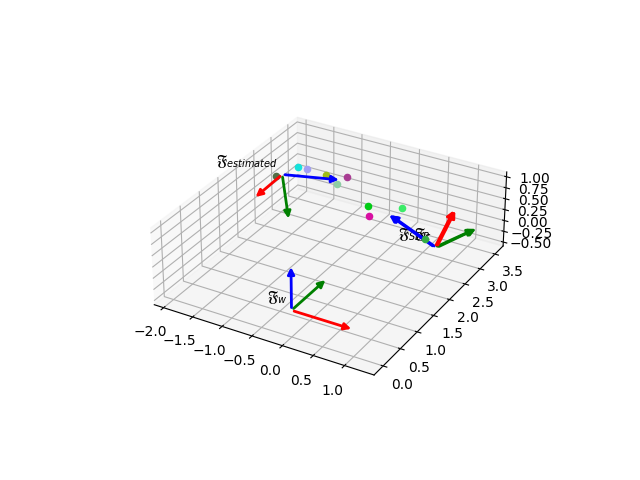

In [209]:
plotting.add_coordinate_frame(np.linalg.inv(T_sdp), ax, "$\mathfrak{F}_{SDP}$")
fig

<IPython.core.display.Javascript object>


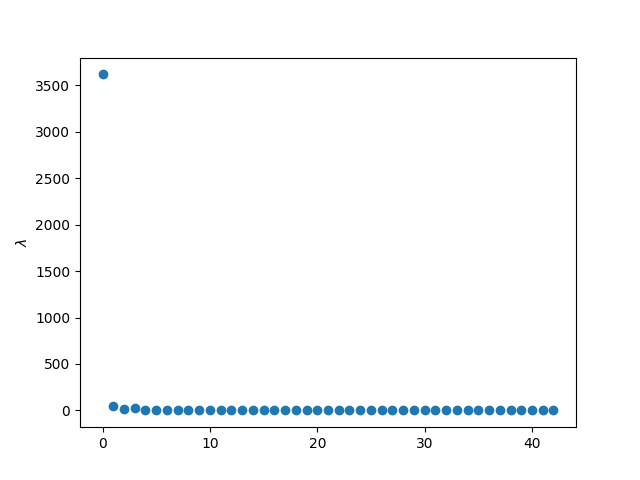

In [214]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
plt.savefig("eigs.png")

/var/folders/_y/_blng15n30s1q2gzf3p3sw2w0000gn/T/ipykernel_61840/1392389762.py:4: RuntimeWarning: invalid value encountered in log
  plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))


<IPython.core.display.Javascript object>


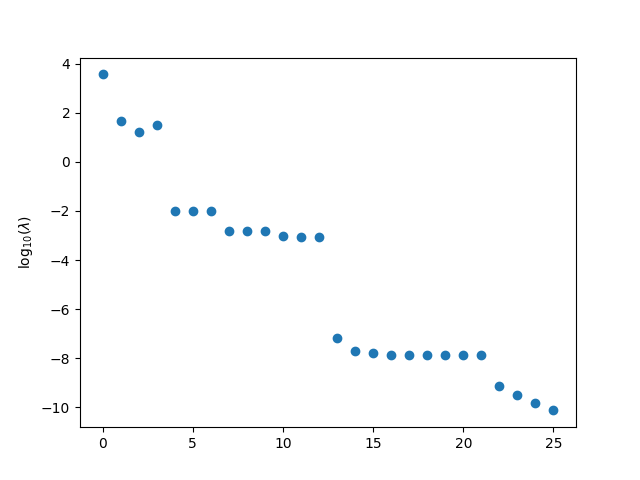

In [215]:
eig_values, eig_vectors = np.linalg.eig(X)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), np.log(eig_values)/np.log(10))
plt.ylabel("$\log_{10}(\lambda)$")
plt.savefig("eigs.png")

# Certificate

In [212]:
# len(As) = 6 + J*3 + 1

In [213]:
lhs = np.concatenate([A @ x_local for A in As], axis = 1) # \in R^((12 + J*5 + 1), (12 + J*3 + 1))
rhs = Q @ x_local
lag_mult = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
lag_mult.shape
H = Q - sum([A * lag_mult[i] for i, A in enumerate(As)])
#np.all(np.linalg.eigvals(H) > 0)
eig_values, _ = np.linalg.eig(H)
plt.close("all")
eig_values
plt.scatter(range(len(eig_values)), eig_values)
plt.ylabel("$\lambda$")
print(f"Minimum eigenvalue of H: {eig_values.min()}, Maximum eigenvalue of H: {eig_values.max()}")

NameError: name 'x_local' is not defined

In [ ]:
# plot the sparsity of the X matrix (should look dense for rank 1)
Hplt = np.zeros((H.shape[0],H.shape[1],3))
Hplt[abs(H)<1e-50] = [1,1,1]
plt.matshow(Hplt, cmap='Greys')
plt.show()